<a href="https://colab.research.google.com/github/Yuma-Ichikawa/pytorch/blob/master/mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLPの作成

### 必要なライブラリをインポート

In [30]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# グラフのスタイル
plt.style.use('seaborn-darkgrid')

### MNIST Datasetを読み込む

In [18]:
# MNIST
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.ToTensor(),
                                           download=True)

In [19]:
image, label = train_dataset[0]
print(f'{image.size()} : {label}')

torch.Size([1, 28, 28]) : 5


## DataLoader

DataLoaderを使用することでバッチサイズだけの画像と正解ラベルをDatasetから取り出す

In [20]:
batch_size = 256


train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

In [21]:
for x, y in train_loader:
    x = x
    y = y

In [23]:
x.size()

torch.Size([96, 1, 28, 28])

## ネットワークの定義

In [24]:
num_classes = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

print(net)

Net(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


In [25]:
# networkをGPUに送信
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = Net().to(device)

## モデルの学習

In [26]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

# 最適化手法を設定
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [27]:
test_loader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

## MNIST

In [28]:
# エポック数
num_epochs = 40

# lossをプロットするためのリスト
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    #epoch毎に初期化
    train_loss = 0
    val_loss = 0
    # trainモードへ切替
    net.train()
    # ミニバッチで分割して読み込む
    for i, (images, labels) in enumerate(train_loader):
        # viewで1次元配列に変更
        # toでgpuに転送
        images, labels = images.view(-1, 28*28).to(device), labels.to(device)
        # 勾配をリセット
        optimizer.zero_grad()
        # 順伝搬の計算
        outputs = net(images)
        # lossを計算
        loss = criterion(outputs, labels)
        # lossのミニバッチ分をため込む
        train_loss += loss.item()
        # 逆伝搬の計算
        loss.backward()
        # 重みの更新
        optimizer.step()
    # 平均lossと平均accuracyを計算
    mean_train_loss = train_loss / len(train_loader.dataset)

    # 評価モードに切り替え
    net.eval()
    # 評価するとき勾配を計算しないように
    with torch.no_grad():
        for j, (images, labels) in enumerate(test_loader):
            images, labels = images.view(-1, 28*28).to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
        mean_val_loss = val_loss / len(test_loader.dataset)

    # 訓練データのlossと検証データのlossのログ
    print(f'Epoch [{epoch+1}], train_Loss : {mean_train_loss:.4f}, val_Loss : {mean_val_loss:.4f}')
    
    # append
    train_loss_list.append(mean_train_loss)
    val_loss_list.append(mean_val_loss)

Epoch [1], train_Loss : 0.0086, val_Loss : 0.0083
Epoch [2], train_Loss : 0.0070, val_Loss : 0.0056
Epoch [3], train_Loss : 0.0043, val_Loss : 0.0033
Epoch [4], train_Loss : 0.0028, val_Loss : 0.0024
Epoch [5], train_Loss : 0.0022, val_Loss : 0.0020
Epoch [6], train_Loss : 0.0019, val_Loss : 0.0017
Epoch [7], train_Loss : 0.0017, val_Loss : 0.0016
Epoch [8], train_Loss : 0.0016, val_Loss : 0.0015
Epoch [9], train_Loss : 0.0015, val_Loss : 0.0014
Epoch [10], train_Loss : 0.0014, val_Loss : 0.0014
Epoch [11], train_Loss : 0.0014, val_Loss : 0.0013
Epoch [12], train_Loss : 0.0013, val_Loss : 0.0013
Epoch [13], train_Loss : 0.0013, val_Loss : 0.0012
Epoch [14], train_Loss : 0.0013, val_Loss : 0.0012
Epoch [15], train_Loss : 0.0012, val_Loss : 0.0012
Epoch [16], train_Loss : 0.0012, val_Loss : 0.0012
Epoch [17], train_Loss : 0.0012, val_Loss : 0.0011
Epoch [18], train_Loss : 0.0011, val_Loss : 0.0011
Epoch [19], train_Loss : 0.0011, val_Loss : 0.0011
Epoch [20], train_Loss : 0.0011, val_Los

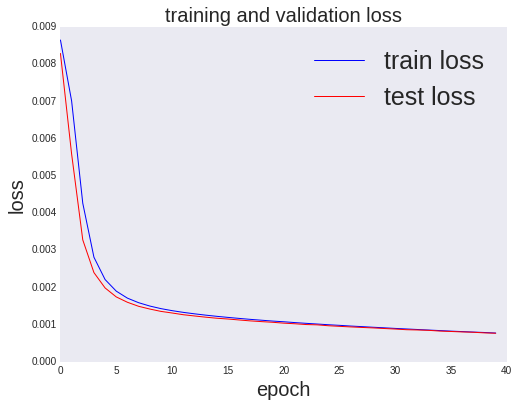

In [40]:
# 誤差をプロットしてみる
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(num_epochs), train_loss_list, c='b', label='train loss')
ax.plot(range(num_epochs), val_loss_list, c='r', label='test loss')
ax.set_xlabel('epoch', fontsize='20')
ax.set_ylabel('loss', fontsize='20')
ax.set_title('training and validation loss', fontsize='20')
ax.grid()
ax.legend(fontsize='25')
plt.show()